In [1]:
import lenstronomy

lenstronomy.__version__

'1.9.3'

In [2]:
import numpy as np
import os
import pickle
import copy
import time
import h5py
from pprint import pprint
import joblib
import gc

from lenstronomy.Util import util
from lenstronomy.Util import param_util
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
from lenstronomy.Sampling.parameters import Param
#from lenstronomy.Analysis.lens_analysis import LensAnalysis
from lenstronomy.Util import mask_util
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Util.util import array2image

import paperfig as pf
pf.set_fontscale(2.)

cwd = os.getcwd()
base_path, _ = os.path.split(cwd)
print('Base directory path:', base_path)

Base directory path: /Users/ajshajib/Research/time_delay_cosmography/J2038/WGD2038-4008/lenstronomy_modeling


In [3]:
from getdist import plots
from getdist import MCSamples
import matplotlib.pyplot as plt
import matplotlib.colors as col
import paperfig as pf

In [4]:
savefig = False

In [5]:
# from https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

## load saved parameter posteriors

In [6]:
mean_gamma, mean_dphi_AB, mean_dphi_AC, mean_dphi_AD = 2.212054295848871, -0.12955683392214323, -0.25935528535071195, -0.6287648176430323

In [36]:
lenstronomy_all_pl_samples = np.loadtxt('../model_posteriors/lenstronomy_all_pl_params.txt')
lenstronomy_all_composite_samples = np.loadtxt('../model_posteriors/lenstronomy_all_comp_params.txt')

#lenstronomy_all_pl_samples[1] = (lenstronomy_all_pl_samples[1] + 1.) * mean_gamma
# lenstronomy_all_pl_samples[4+1] = (lenstronomy_all_pl_samples[5] + 1) * mean_dphi_AB
# lenstronomy_all_pl_samples[5+1] = (lenstronomy_all_pl_samples[6] + 1) * mean_dphi_AC
# lenstronomy_all_pl_samples[6+1] = (lenstronomy_all_pl_samples[7] + 1) * mean_dphi_AD

#all_pl_samples[3] = -(all_pl_samples[3]+90)

lenstronomy_all_composite_samples[1] = (lenstronomy_all_composite_samples[1] + 1)* mean_gamma
lenstronomy_all_composite_samples[4+1] = (lenstronomy_all_composite_samples[4+1] + 1) * mean_dphi_AB
lenstronomy_all_composite_samples[5+1] = (lenstronomy_all_composite_samples[5+1] + 1) * mean_dphi_AC
lenstronomy_all_composite_samples[6+1] = (lenstronomy_all_composite_samples[6+1] + 1) * mean_dphi_AD


In [37]:
lenstronomy_all_pl_samples[9] = (-lenstronomy_all_pl_samples[9] + 90)
lenstronomy_all_pl_samples[3] = (-lenstronomy_all_pl_samples[3] + 90 - 180)

In [38]:
glee_pl_samples = np.genfromtxt('../model_posteriors/glee_desj2038_modelparams_weight_pl.dat', skip_header=1, delimiter=',')
glee_composite_samples = np.genfromtxt('../model_posteriors/glee_desj2038_modelparams_weight_comp.dat', skip_header=1, delimiter=',')

glee_pl_samples[:, [9, 10, 11]] *= -1
#glee_pl_samples[:, 5] = - (glee_pl_samples[:, 5] - 90) 
#glee_pl_samples[:, 7] = - (glee_pl_samples[:, 7] + 90) 

glee_composite_samples[:, [5, 6, 7]] *= -1

#glee_composite_samples

In [39]:
glee_pl_indices = np.random.choice(np.arange(glee_pl_samples.shape[0]), size=1000, p=glee_pl_samples[:, 1]/np.sum(glee_pl_samples[:, 1]))
glee_comp_indices = np.random.choice(np.arange(glee_composite_samples.shape[0]), size=1000, p=glee_composite_samples[:, 1]/np.sum(glee_composite_samples[:, 1]))

In [40]:
glee_pl_samples_eq_weight = glee_pl_samples[glee_pl_indices, :]
glee_composite_samples_eq_weight = glee_composite_samples[glee_comp_indices, :]

In [41]:
# columan headers: weight, td_ab, td_ac, td_ad, reP_sph, q, theta_q, gam, gamma_ext, theta_gamma

Power-law smaples: 4091
Removed no burn in
Removed no burn in


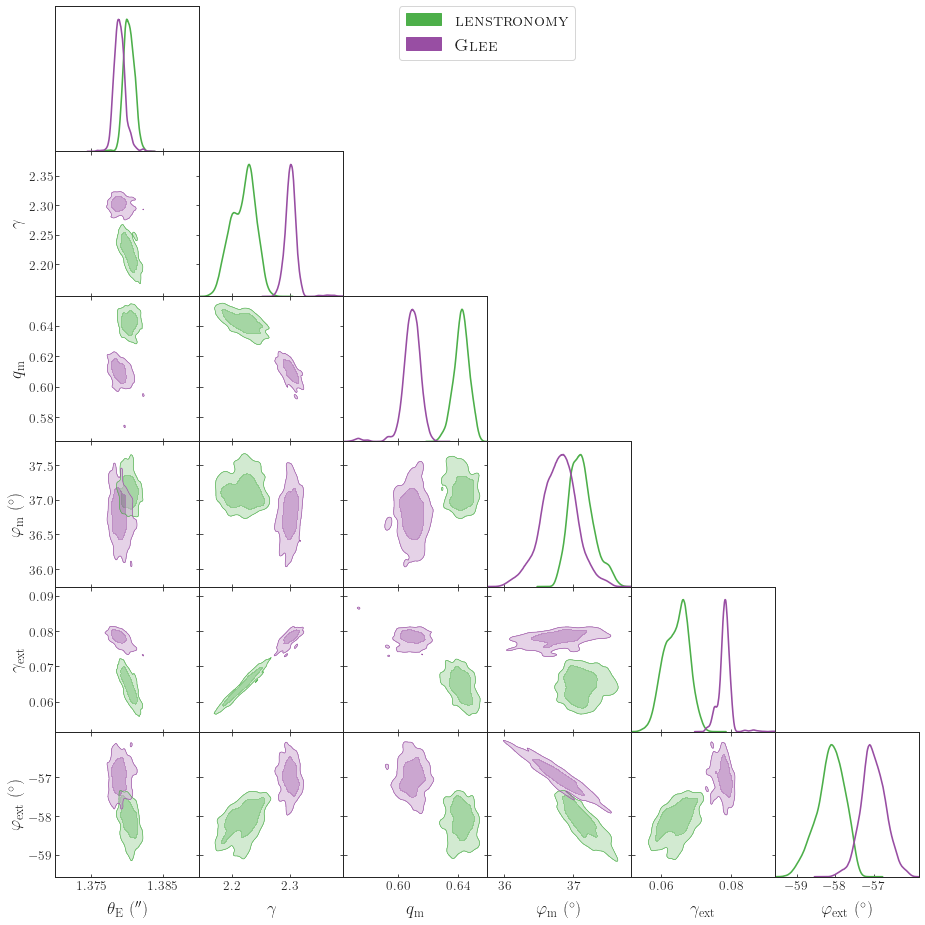

In [42]:
%matplotlib inline

import matplotlib as mpl

mpl.rcParams['text.usetex'] = True
#mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

smoothing_scale = 0.3    

print('Power-law smaples: {}'.format(lenstronomy_all_pl_samples.shape[1]))


lenstronomy_powerlaw_mc_samples= MCSamples(samples=lenstronomy_all_pl_samples[[0, 1, 8, 9, 2, 3], :].T, 
                               names=['theta_E', 
                                      'gamma', 'q_m', 'phi_m', 'gamma_ext', 'psi_ext', #'invariant_grad',
                                      #'dphi_AB', 'dphi_AC', 'dphi_AD'
                                     ], 
                              labels=['{\\theta}_{\\rm{E}} \ (^{\prime\prime})', 
                                      '\\gamma', #'{\\gamma}/\\overline{{\\gamma}} - 1',
                                      'q_{\\rm m}',
                                      '\\varphi_{\\rm m} {\ (^{\circ})}',
                                      '\\gamma_{\\rm{ext}}', 
                                      '\\varphi_{\\rm{ext}} {\ (^{\circ})}',   
                                      #'\\xi_{\\rm rad}',
                                      #'\\Delta \\phi^{\\rm model}_{\\rm AB}', #'\\Delta \\phi^{\\rm eff}_{\\rm AB} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AB}} - 1',
                                      #'\\Delta \\phi^{\\rm model}_{\\rm AC}', #'\\Delta \\phi^{\\rm eff}_{\\rm AC} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AC}} - 1',
                                      #'\\Delta \\phi^{\\rm model}_{\\rm AD}', #'\\Delta \\phi^{\\rm eff}_{\\rm AD} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AD}} - 1',
                                     ],
                  )
lenstronomy_powerlaw_mc_samples.updateSettings({'smooth_scale_2D': smoothing_scale})
lenstronomy_powerlaw_mc_samples.updateSettings({'smooth_scale_1D': smoothing_scale})


# index,final_wht,theta_E,gamma,q_mass,PA_mass,gamma_ext,phi_ext,vd_pred,phi_ab,phi_ac,phi_ad,phi_bc,phi_bd,phi_cd

glee_powerlaw_mc_samples= MCSamples(samples=glee_pl_samples_eq_weight[:, [2, 3, 4, 5, 6, 7]], 
                                    #weights=glee_pl_samples[:, 1],
                               names=['theta_E', 
                                      'gamma', 'q_m', 'phi_m', 'gamma_ext', 'psi_ext', #'invariant_grad',
                                      #'dphi_AB', 'dphi_AC', 'dphi_AD'
                                     ], 
                              labels=['{\\theta}_{\\rm{E}} \ (^{\prime\prime})', 
                                      '\\gamma', #'{\\gamma}/\\overline{{\\gamma}} - 1',
                                      'q_{\\rm m}',
                                      '\\varphi_{\\rm m} {\ (^{\circ})}',
                                      '\\gamma_{\\rm{ext}}', 
                                      '\\varphi_{\\rm{ext}} {\ (^{\circ})}',  
                                      #'\\xi_{\\rm rad}',
                                      #'\\Delta \\phi^{\\rm model}_{\\rm AB}', #'\\Delta \\phi^{\\rm eff}_{\\rm AB} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AB}} - 1',
                                      #'\\Delta \\phi^{\\rm model}_{\\rm AC}', #'\\Delta \\phi^{\\rm eff}_{\\rm AC} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AC}} - 1',
                                      #'\\Delta \\phi^{\\rm model}_{\\rm AD}', #'\\Delta \\phi^{\\rm eff}_{\\rm AD} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AD}} - 1',
                                     ],
                  )
glee_powerlaw_mc_samples.updateSettings({'smooth_scale_2D': smoothing_scale})
glee_powerlaw_mc_samples.updateSettings({'smooth_scale_1D': smoothing_scale})
    
### 

pf.set_fontscale(2.)

g = plots.getSubplotPlotter(subplot_size=2.2)
g.settings.lw_contour = 1.
g.settings.alpha_factor_contour_lines = 2.
g.settings.solid_contour_palefactor = 0.5
g.settings.axes_fontsize = 16
g.settings.lab_fontsize = 20

g.settings.legend_fontsize = 20

colors = [pf.cb_green, pf.cb_purple]

g.triangle_plot([lenstronomy_powerlaw_mc_samples, glee_powerlaw_mc_samples],
                 legend_labels=['$\\textsc{lenstronomy}$', '$\\textsc{Glee}$'],
                 filled=True, shaded=False,
                 alpha_filled_add=.5, 
                 contour_lws=[1.6, 1.6], 
                 contour_ls=['-', '-'],
                 #filled=False,
                 #contour_colors=[sns.xkcd_rgb['emerald'], sns.xkcd_rgb['bright orange']], 
                 contour_args={'alpha': .5},
                 #line_args={'lw': 7., "zorder": 30},
                 #line_args={'lw': 1., 'alpha': 1.}
                 contour_colors=colors,
                 param_limits={'theta_E': (1.37, 1.39), #'psi_ext': (-38, -26), 
                               #'invariant_grad': (-0.8, 0.8)
                              },
                 #fontsize=100
               )


#g.fig.tight_layout()
if False:
    #pass
    g.fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/pl_model_compare_lenstronomy_glee.pdf', bbox_inches='tight')

In [16]:
# print out lenstronomy constraints

params = ['theta_E', 'gamma', 'q_m', 'phi_m', 'gamma_ext', 'psi_ext']
lenstronomy_index = [0, 1, 8, 9, 2, 3]
glee_index = [2, 3, 4, 5, 6, 7]

for li, gi, p in zip(lenstronomy_index, glee_index, params):
    lenstrnomy_lo, lenstrnomy_med, lenstrnomy_hi =  np.percentile(lenstronomy_all_pl_samples[li], q=[16, 50, 84])

    glee_lo, glee_med, glee_hi = np.percentile(glee_pl_samples_eq_weight[:, gi], q=[16, 50, 84])

    print('lenstrnomy {}: {:.3f} - {:.3f} + {:.3f}'.format(p, lenstrnomy_med, (lenstrnomy_med - lenstrnomy_lo), (lenstrnomy_hi - lenstrnomy_med)))
    print('glee {}: {:.3f} - {:.3f} + {:.3f}'.format(p, glee_med, (glee_med - lenstrnomy_lo), (glee_hi - glee_med)))
    print('')
      
# print('Differnce: {:.3f}%, {:.3f}sigma'.format(
#     np.abs(lenstrnomy_gamma_med - glee_gamma_med) / np.max([lenstrnomy_gamma_med, glee_gamma_med]) * 100,
#     np.abs(lenstrnomy_gamma_med - glee_gamma_med) / np.sqrt((lenstrnomy_gamma_hi - lenstrnomy_gamma_lo)**2 + (glee_gamma_hi - glee_gamma_lo)**2) * 2.,
# ))


lenstrnomy theta_E: 1.380 - 0.001 + 0.001
glee theta_E: 1.379 - -0.001 + 0.001

lenstrnomy gamma: 2.223 - 0.025 + 0.018
glee gamma: 2.301 - 0.104 + 0.009

lenstrnomy q_m: 0.643 - 0.005 + 0.005
glee q_m: 0.610 - -0.027 + 0.005

lenstrnomy phi_m: 37.108 - 0.160 + 0.193
glee phi_m: 36.777 - -0.170 + 0.268

lenstrnomy gamma_ext: 0.065 - 0.004 + 0.003
glee gamma_ext: 0.078 - 0.017 + 0.001

lenstrnomy psi_ext: -58.093 - 0.399 + 0.349
glee psi_ext: -56.983 - 1.509 + 0.311



In [13]:
# compare gamma
lenstrnomy_gamma_lo, lenstrnomy_gamma_med, lenstrnomy_gamma_hi =  np.percentile(lenstronomy_all_pl_samples[1], q=[16, 50, 84])

glee_gamma_lo, glee_gamma_med, glee_gamma_hi = np.percentile(glee_pl_samples_eq_weight[:, 3], q=[16, 50, 84])

print('lenstrnomy: {:.2f} +- {:.2f}'.format(lenstrnomy_gamma_med, (lenstrnomy_gamma_hi - lenstrnomy_gamma_lo)/2.))
print('glee: {:.2f} +- {:.2f}'.format(glee_gamma_med, (glee_gamma_hi-glee_gamma_lo)/2.))
      
print('Differnce: {:.2f}%, {:.2f}sigma'.format(
    np.abs(lenstrnomy_gamma_med - glee_gamma_med) / np.max([lenstrnomy_gamma_med, glee_gamma_med]) * 100,
    np.abs(lenstrnomy_gamma_med - glee_gamma_med) / np.sqrt((lenstrnomy_gamma_hi - lenstrnomy_gamma_lo)**2 + (glee_gamma_hi - glee_gamma_lo)**2) * 2.,
))


lenstrnomy: 2.22 +- 0.02
glee: 2.30 +- 0.01
Differnce: 3.43%, 3.37sigma


In [14]:
# compare shear
lenstrnomy_shear_lo, lenstrnomy_shear_med, lenstrnomy_shear_hi =  np.percentile(lenstronomy_all_pl_samples[2], q=[16, 50, 84])

glee_shear_lo, glee_shear_med, glee_shear_hi = np.percentile(glee_pl_samples_eq_weight[:, 6], q=[16, 50, 84])

print('lenstrnomy: {:.3f} +- {:.3f}'.format(lenstrnomy_shear_med, (lenstrnomy_shear_hi - lenstrnomy_shear_lo)/2.))
print('glee: {:.3f} +- {:.3f}'.format(glee_shear_med, (glee_shear_hi-glee_shear_lo)/2.))
  
print('Differnce: {:.2f}%, {:.2f}sigma'.format(
    np.abs(lenstrnomy_shear_med - glee_shear_med) / np.max([lenstrnomy_shear_med, glee_shear_med]) * 100,
    np.abs(lenstrnomy_shear_med - glee_shear_med) / np.sqrt((lenstrnomy_shear_hi - lenstrnomy_shear_lo)**2 + (glee_shear_hi - glee_shear_lo)**2) * 2.,
))

lenstrnomy: 0.065 +- 0.004
glee: 0.078 +- 0.002
Differnce: 17.25%, 3.46sigma


In [15]:
# compare Fermat potentials

for i in range(3):    
    lenstrnomy_pot_lo, lenstrnomy_pot_med, lenstrnomy_pot_hi =  np.percentile(lenstronomy_all_pl_samples[5+i], q=[16, 50, 84])

    glee_pot_lo, glee_pot_med, glee_pot_hi = np.percentile(glee_pl_samples_eq_weight[:, 9+i], q=[16, 50, 84])

    print('{} Differnce: {:.2f}%, {:.2f}sigma'.format( 
        ['AB', 'AC', 'AD'][i],
        np.abs(lenstrnomy_pot_med - glee_pot_med) / np.max([lenstrnomy_pot_med, glee_pot_med]) * 100,
        np.abs(lenstrnomy_pot_med - glee_pot_med) / np.sqrt((lenstrnomy_pot_hi - lenstrnomy_pot_lo)**2 + (glee_pot_hi - glee_pot_lo)**2) * 2.,
    ))

AB Differnce: -79.94%, 1.43sigma
AC Differnce: 295.67%, 92.90sigma
AD Differnce: 328.24%, 103.16sigma


Lenstronomy power-law smaples: 4091
Removed no burn in
Removed no burn in


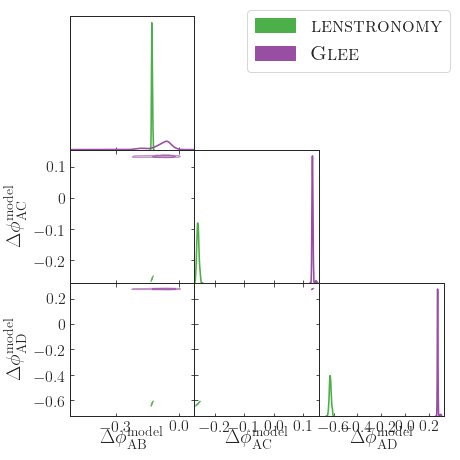

In [16]:
%matplotlib inline

smoothing_scale = 0.3    

print('Lenstronomy power-law smaples: {}'.format(lenstronomy_all_pl_samples.shape[1]))


lenstronomy_composite_mc_samples= MCSamples(samples=lenstronomy_all_pl_samples[[5, 6, 7], :].T, 
                               names=[#'theta_E', 
                                      #'gamma', 'gamma_ext', 'psi_ext', #'invariant_grad',
                                      'dphi_AB', 'dphi_AC', 'dphi_AD'
                                     ], 
                              labels=[#'{\\theta}_{\\rm{E}}', 
                                      #'{\\rm Blinded}\\ \\gamma', #'{\\gamma}/\\overline{{\\gamma}} - 1',
                                      #'\\gamma_{\\rm{ext}}', 
                                      #'\\psi_{\\rm{ext}} {\\rm\ (deg)}', 
                                      #'\\xi_{\\rm rad}',
                                      '\\Delta \\phi^{\\rm model}_{\\rm AB}', #'\\Delta \\phi^{\\rm eff}_{\\rm AB} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AB}} - 1',
                                      '\\Delta \\phi^{\\rm model}_{\\rm AC}', #'\\Delta \\phi^{\\rm eff}_{\\rm AC} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AC}} - 1',
                                      '\\Delta \\phi^{\\rm model}_{\\rm AD}', #'\\Delta \\phi^{\\rm eff}_{\\rm AD} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AD}} - 1',
                                     ],
                  )
lenstronomy_composite_mc_samples.updateSettings({'smooth_scale_2D': smoothing_scale})
lenstronomy_composite_mc_samples.updateSettings({'smooth_scale_1D': smoothing_scale})


# index,final_wht,gamma_ext,phi_ext,vd_pred,phi_ab,phi_ac,phi_ad,phi_bc,phi_bd,phi_cd

glee_composite_mc_samples= MCSamples(samples=glee_pl_samples_eq_weight[:, [9, 10, 11]], 
                                    #weights=glee_pl_samples[:, 1],
                               names=[#'theta_E', 
                                      #'gamma', 'gamma_ext', 'psi_ext', #'invariant_grad',
                                      'dphi_AB', 'dphi_AC', 'dphi_AD'
                                     ], 
                              labels=[#'{\\theta}_{\\rm{E}}', 
                                      #'{\\rm Blinded}\\ \\gamma', #'{\\gamma}/\\overline{{\\gamma}} - 1',
                                      #'\\gamma_{\\rm{ext}}', 
                                      #'\\psi_{\\rm{ext}} {\\rm\ (deg)}', 
                                      #'\\xi_{\\rm rad}',
                                      '\\Delta \\phi^{\\rm model}_{\\rm AB}', #'\\Delta \\phi^{\\rm eff}_{\\rm AB} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AB}} - 1',
                                      '\\Delta \\phi^{\\rm model}_{\\rm AC}', #'\\Delta \\phi^{\\rm eff}_{\\rm AC} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AC}} - 1',
                                      '\\Delta \\phi^{\\rm model}_{\\rm AD}', #'\\Delta \\phi^{\\rm eff}_{\\rm AD} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AD}} - 1',
                                     ],
                  )
glee_composite_mc_samples.updateSettings({'smooth_scale_2D': smoothing_scale})
glee_composite_mc_samples.updateSettings({'smooth_scale_1D': smoothing_scale})
    
### 

pf.set_fontscale(2.)

g = plots.getSubplotPlotter(subplot_size=2.2)
g.settings.lw_contour = 1.
g.settings.alpha_factor_contour_lines = 2.
g.settings.solid_contour_palefactor = 0.5
g.settings.axes_fontsize = 16
g.settings.lab_fontsize = 20

g.settings.legend_fontsize = 20

#colors = [pf.cb_red, pf.cb_blue]

g.triangle_plot([lenstronomy_composite_mc_samples, glee_composite_mc_samples],
                 legend_labels=[r'$\textsc{lenstronomy}$', r'$\textsc{Glee}$'],
                 filled=True, shaded=False,
                 alpha_filled_add=.5, 
                 contour_lws=[1.6, 1.6], 
                 contour_ls=['-', '-'],
                 #filled=False,
                 #contour_colors=[sns.xkcd_rgb['emerald'], sns.xkcd_rgb['bright orange']], 
                 contour_args={'alpha': .5},
                 #line_args={'lw': 7., "zorder": 30},
                 #line_args={'lw': 1., 'alpha': 1.}
                 contour_colors=colors,
                 param_limits={'theta_E': (1.31, 1.41), #'psi_ext': (-38, -26), 
                               #'invariant_grad': (-0.8, 0.8)
                              },
                 #fontsize=100
               )


#g.fig.tight_layout()
if savefig:
    #pass
    g.fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/pl_pot_compare_lenstronomy_glee.pdf', bbox_inches='tight')

Lenstronomy power-law smaples: 4091
Removed no burn in
Removed no burn in


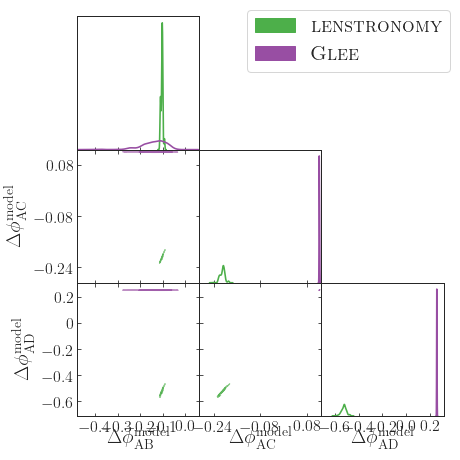

In [17]:
%matplotlib inline

smoothing_scale = 0.3    

print('Lenstronomy power-law smaples: {}'.format(lenstronomy_all_pl_samples.shape[1]))


lenstronomy_composite_mc_samples= MCSamples(samples=lenstronomy_all_composite_samples[[5, 6, 7], :].T, 
                               names=[#'theta_E', 
                                      #'gamma', 'gamma_ext', 'psi_ext', #'invariant_grad',
                                      'dphi_AB', 'dphi_AC', 'dphi_AD'
                                     ], 
                              labels=[#'{\\theta}_{\\rm{E}}', 
                                      #'{\\rm Blinded}\\ \\gamma', #'{\\gamma}/\\overline{{\\gamma}} - 1',
                                      #'\\gamma_{\\rm{ext}}', 
                                      #'\\psi_{\\rm{ext}} {\\rm\ (deg)}', 
                                      #'\\xi_{\\rm rad}',
                                      '\\Delta \\phi^{\\rm model}_{\\rm AB}', #'\\Delta \\phi^{\\rm eff}_{\\rm AB} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AB}} - 1',
                                      '\\Delta \\phi^{\\rm model}_{\\rm AC}', #'\\Delta \\phi^{\\rm eff}_{\\rm AC} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AC}} - 1',
                                      '\\Delta \\phi^{\\rm model}_{\\rm AD}', #'\\Delta \\phi^{\\rm eff}_{\\rm AD} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AD}} - 1',
                                     ],
                  )
lenstronomy_composite_mc_samples.updateSettings({'smooth_scale_2D': smoothing_scale})
lenstronomy_composite_mc_samples.updateSettings({'smooth_scale_1D': smoothing_scale})


# index,final_wht,gamma_ext,phi_ext,vd_pred,phi_ab,phi_ac,phi_ad,phi_bc,phi_bd,phi_cd

glee_composite_mc_samples= MCSamples(samples=glee_composite_samples_eq_weight[:, [5, 6, 7]], 
                                    #weights=glee_pl_samples[:, 1],
                               names=[#'theta_E', 
                                      #'gamma', 'gamma_ext', 'psi_ext', #'invariant_grad',
                                      'dphi_AB', 'dphi_AC', 'dphi_AD'
                                     ], 
                              labels=[#'{\\theta}_{\\rm{E}}', 
                                      #'{\\rm Blinded}\\ \\gamma', #'{\\gamma}/\\overline{{\\gamma}} - 1',
                                      #'\\gamma_{\\rm{ext}}', 
                                      #'\\psi_{\\rm{ext}} {\\rm\ (deg)}', 
                                      #'\\xi_{\\rm rad}',
                                      '\\Delta \\phi^{\\rm model}_{\\rm AB}', #'\\Delta \\phi^{\\rm eff}_{\\rm AB} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AB}} - 1',
                                      '\\Delta \\phi^{\\rm model}_{\\rm AC}', #'\\Delta \\phi^{\\rm eff}_{\\rm AC} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AC}} - 1',
                                      '\\Delta \\phi^{\\rm model}_{\\rm AD}', #'\\Delta \\phi^{\\rm eff}_{\\rm AD} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AD}} - 1',
                                     ],
                  )
glee_composite_mc_samples.updateSettings({'smooth_scale_2D': smoothing_scale})
glee_composite_mc_samples.updateSettings({'smooth_scale_1D': smoothing_scale})
    
### 

pf.set_fontscale(2.)

g = plots.getSubplotPlotter(subplot_size=2.2)
g.settings.lw_contour = 1.
g.settings.alpha_factor_contour_lines = 2.
g.settings.solid_contour_palefactor = 0.5
g.settings.axes_fontsize = 16
g.settings.lab_fontsize = 20

g.settings.legend_fontsize = 20

#colors = [pf.cb_red, pf.cb_blue]

g.triangle_plot([lenstronomy_composite_mc_samples, glee_composite_mc_samples],
                 legend_labels=[r'$\textsc{lenstronomy}$', r'$\textsc{Glee}$'],
                 filled=True, shaded=False,
                 alpha_filled_add=.5, 
                 contour_lws=[1.6, 1.6], 
                 contour_ls=['-', '-'],
                 #filled=False,
                 #contour_colors=[sns.xkcd_rgb['emerald'], sns.xkcd_rgb['bright orange']], 
                 contour_args={'alpha': .5},
                 #line_args={'lw': 7., "zorder": 30},
                 #line_args={'lw': 1., 'alpha': 1.}
                 contour_colors=colors,
                 param_limits={'theta_E': (1.31, 1.41), #'psi_ext': (-38, -26), 
                               #'invariant_grad': (-0.8, 0.8)
                              },
                 #fontsize=100
               )


#g.fig.tight_layout()
if savefig:
    #pass
    g.fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/composite_pot_compare_lenstronomy_glee.pdf', bbox_inches='tight')